In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from tqdm.auto import tqdm
import random
import librosa
import librosa.display
import torch
import torchaudio
import IPython.display as ipd
import os
import warnings
warnings.filterwarnings(action='ignore') 

###data augmentation

In [ ]:
# noise 추가
def noise(sample):
    noise_amp = 0.01*np.random.uniform()*np.amax(sample)
    sample = sample + noise_amp*np.random.normal(size = sample.shape[0])
    return sample

# time stretching
def stretch(sample, rate = 0.8):
    stretch_sample = librosa.effects.time_stretch(sample, rate)
    return stretch_sample

# pitch 변환
def pitch(sample, sampling_rate, pitch_factor = 0.8):
    pitch_sample = librosa.effects.pitch_shift(sample, sampling_rate, pitch_factor)
    return pitch_sample

###audio feature extraction

In [ ]:
CFG = {
    'SR':16000,
    'N_melspectrogram':32, # MFCC 벡터를 추출할 개수
    'SEED':41
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

###melspectrogram

In [ ]:
def get_mfcc_feature(df, data_type, save_path):
    # train feature engineering
    # Data Folder path
    root_folder = '/content'
    save_path = './train_melspectrogram_data.csv'
    if os.path.exists(save_path):
        print(f'{save_path} is exist.')
        
    features = []
    log_specgrams_hp = []
    f_list1=[]
    f_list2=[]
    f_list3=[]

    for uid in tqdm(df['id']):
        
        root_path = os.path.join(root_folder, 'train')
        path = os.path.join(root_path, str(uid).zfill(5)+'.wav')
        
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        y = noise(y)
        y = stretch(y)
        y = pitch(y,sr)
        # feature1
        # librosa패키지를 사용하여 melspectrogram 추출
        melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=CFG['N_melspectrogram'])
        y_feature3 = []
        for e in melspectrogram:
            y_feature3.append(np.mean(librosa.feature.delta(e)))
        f_list3.append(y_feature3)

        # log sccale로 변환
        feature1 = librosa.power_to_db(S=melspectrogram, ref=1.0)
        
        # 추출된 melspectrogram들의 평균을 Feature로 사용
        y_feature1 = []
        
        for e in feature1:
            y_feature1.append(np.mean(e))    
        f_list1.append(y_feature1)
        
        
        # feature2
        # librosa.effects.hpss를 사용한 feature 추출
        y_harmonic, y_percussive = librosa.effects.hpss(y)
        melspec_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels = CFG['N_melspectrogram'])
        melspec_percussive = librosa.feature.melspectrogram(y_percussive, n_mels = CFG['N_melspectrogram'])
        logspec_harmonic = librosa.amplitude_to_db(melspec_harmonic)
        logspec_percussive = librosa.amplitude_to_db(melspec_percussive)
        logspec_hp = np.average([logspec_harmonic, logspec_percussive], axis=0)

        y_feature2 = []
        for e in logspec_hp:
            y_feature2.append(np.mean(e))
        f_list2.append(y_feature2)
                              
    
    # 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
    f_list1 = pd.DataFrame(f_list1)
    f_list2 = pd.DataFrame(f_list2)
    f_list3 = pd.DataFrame(f_list3)

    f_list1.columns = ['melspectrogram_1_'+str(x) for x in range(1,CFG['N_melspectrogram']+1)]
    f_list2.columns = ['melspectrogram_2_'+str(x) for x in range(1,CFG['N_melspectrogram']+1)]
    f_list3.columns = ['melspectrogram_3_'+str(x) for x in range(1,CFG['N_melspectrogram']+1)]

    melspectrogram_train_df = pd.concat([f_list1,f_list2,f_list3], axis=1)
    train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_data.csv')
    train_df = pd.concat([train_df, melspectrogram_train_df], axis=1)
    train_df.to_csv('./train_melspectrogram_3features_data.csv', index=False)
    print('Done.')

In [ ]:
get_mfcc_feature(train_df,'train','./train_mfcc_data.csv')

  0%|          | 0/3805 [00:00<?, ?it/s]

Done.


###GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(train_x, train_y)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10}
최고 예측 정확도: 0.9206


### RF model

In [ ]:
train_df = pd.read_csv('/content/train_melspectrogram_3features_data.csv')
train_x = train_df.drop(columns=['id', 'covid19'])
train_y = train_df['covid19']

In [ ]:
def onehot_encoding(ohe, x):
    # 학습데이터로 부터 fit된 one-hot encoder (ohe)를 받아 transform 시켜주는 함수
    encoded = ohe.transform(x['gender'].values.reshape(-1,1))
    encoded_df = pd.DataFrame(encoded, columns=ohe.categories_[0])
    x = pd.concat([x.drop(columns=['gender']), encoded_df], axis=1)
    return x

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
ohe.fit(train_x['gender'].values.reshape(-1,1))
train_x = onehot_encoding(ohe, train_x)

In [ ]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.linear_model import LogisticRegression


# 개별 ML 모델을 위한 Classifier 생성.
rf_clf = RandomForestClassifier(max_depth= 6, min_samples_leaf= 8, min_samples_split= 8, n_estimators= 10) #you

# 개별 모델들을 학습. 
rf_clf.fit(train_x , train_y)

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
rf_pred = rf_clf.predict(valid_x)

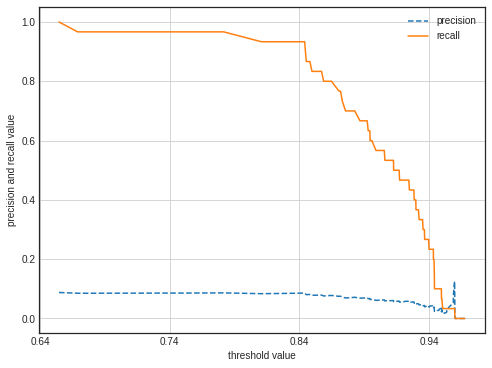

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
def precision_recall_curve_plot(valid_y,rf_preds):
  precisions, recalls, thresholds = precision_recall_curve(valid_y,rf_preds)

  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary],linestyle='--',label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  start,end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  plt.xlabel('threshold value')
  plt.ylabel('precision and recall value')
  plt.legend()
  plt.grid()
  plt.show()
precision_recall_curve_plot(valid_y,pred_proba_class0)

In [ ]:
rf_preds = pd.DataFrame(np.where((rf_clf.predict_proba(valid_x)>0.96),0,1))
rf_preds= pd.DataFrame(rf_preds.iloc[:,0])

In [ ]:
rf_preds.value_counts()

1    356
0     25
dtype: int64

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(valid_y,rf_preds)
print('f1스코어:{0:.4f}'.format(f1))

f1스코어:0.1641


In [ ]:
test_df = pd.read_csv('/content/test_melspectrogram_3features_data.csv')
test_x = test_df.drop(columns=['id'])
ohe.fit(test_x['gender'].values.reshape(-1,1))
test_x = onehot_encoding(ohe, test_x)
pred_w = pd.DataFrame(np.where((rf_clf.predict_proba(test_x)>0.715),0,1))
pred_w = pd.DataFrame(pred_w.iloc[:,0])
#pred_w = pred_w[0].to_numpy()
pred_w.value_counts()

0    5674
1      58
dtype: int64

In [ ]:
submission = pd.read_csv( '/content/sample_submission.csv')
submission['covid19'] = pred_w
submission.to_csv( 'submit0707_7.csv', index=False)

###lightgbm

In [ ]:
# 앞서 XGBoost와 동일하게 n_estimators는 400 설정. 
from lightgbm import LGBMClassifier

lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
evals = [(train_x, train_y)]
lgbm_wrapper.fit(train_x, train_y, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(train_x,)
pred_proba = lgbm_wrapper.predict_proba(train_x,)[:, 1]

In [ ]:
preds = pd.DataFrame(np.where((lgbm_wrapper.predict_proba(valid_x)>0.995),0,1))
preds= pd.DataFrame(preds.iloc[:,0])

In [ ]:
preds.value_counts()

0    352
1     29
dtype: int64

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(valid_y,preds)
print('f1스코어:{0:.4f}'.format(f1))

f1스코어:0.9613


In [ ]:
test_df = pd.read_csv('/content/test_melspectrogram_3features_data.csv')
test_x = test_df.drop(columns=['id'])
ohe.fit(test_x['gender'].values.reshape(-1,1))
test_x = onehot_encoding(ohe, test_x)
pred_w = pd.DataFrame(np.where((rf_clf.predict_proba(test_x)>0.75),0,1))
pred_w = pd.DataFrame(pred_w.iloc[:,0])
#pred_w = pred_w[0].to_numpy()
pred_w.value_counts()

0    5267
1     465
dtype: int64

In [ ]:
submission = pd.read_csv( '/content/sample_submission.csv')
submission['covid19'] = pred_w
submission.to_csv( 'submit0707_6.csv', index=False)

###voting(logistic regression, kneighbors classifier)

In [ ]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
train_x = np.array(train_x)
train_y = np.array(train_y)
valid_x = np.array(valid_x)
valid_y = np.array(valid_y)

In [ ]:
# 개별 모델은 로지스틱 회귀와 KNN 임. 
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('KNN',knn_clf)] , voting='soft' )

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(train_x , train_y)
pred = vo_clf.predict(valid_x)
#print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(valid_y , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(train_x , train_y)
    pred = classifier.predict(valid_x)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(valid_y , pred)))

LogisticRegression 정확도: 0.9126
KNeighborsClassifier 정확도: 0.9191


In [ ]:
pred_w = pd.DataFrame(np.where((vo_clf.predict_proba(valid_x)>0.83),0,1))
pred_w = pd.DataFrame(pred_w.iloc[:,0])

In [ ]:
pred_w.value_counts()

0    276
1     33
dtype: int64

In [ ]:
pred_w = pd.DataFrame(np.where((vo_clf.predict_proba(test_x)>0.83),0,1))
pred_w = pd.DataFrame(pred_w.iloc[:,0])

In [ ]:
pred_w.value_counts()

0    5220
1     512
dtype: int64

In [ ]:
submission = pd.read_csv( '/content/sample_submission.csv')
submission['covid19'] = pred_w
submission.to_csv( 'submit0707_8.csv', index=False)

In [ ]:
s = pd.read_csv('/content/submit0707_8.csv')

In [ ]:
s

,id,covid19
0,3806,0
1,3807,0
2,3808,0
3,3809,0
4,3810,0
...,...,...
5727,9533,0
5728,9534,0
5729,9535,0
5730,9536,1


###SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
# 훈련데이터에 대해 스케일링 적용을 위한 조사
scaler = MinMaxScaler()
scaler.fit(train_x)
train_x_scaled = scaler.transform(train_x)
valid_x_scaled = scaler.transform(valid_x)
model = SVC(kernel='rbf',probability=True)
model.fit(train_x_scaled, train_y)

print("훈련 세트 정확도: {:.3f}".format(model.score(train_x_scaled, train_y)))
print("테스트 세트 정확도: {:.3f}".format(model.score(valid_x_scaled, valid_y)))

훈련 세트 정확도: 0.922
테스트 세트 정확도: 0.919


In [ ]:
svc_preds = pd.DataFrame(np.where((model.predict_proba(valid_x)>0.9),0,1))
svc_preds= pd.DataFrame(svc_preds.iloc[:,0])

In [ ]:
rf_preds.value_counts()

1    356
0     25
dtype: int64

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(valid_y,rf_preds)
print('f1스코어:{0:.4f}'.format(f1))

### hyper optimizer

In [ ]:
from hyperopt import STATUS_OK
from sklearn.model_selection import cross_val_score
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                           min_child_weight=int(search_space['min_child_weight']),
                           learning_rate=search_space['learning_rate'],
                           colsample_bytree = search_space['colsample_bytree'],
                           eval_metric ='logloss')
    accuracy = cross_val_score(xgb_clf,train_x,train_y,scoring='accuracy',cv=3)
    
    return {'loss':-1*np.mean(accuracy),'status':STATUS_OK}

from hyperopt import hp
xgb_search_space = {
    'max_depth':hp.quniform('max_depth',5,20,1),
    'min_child_weight':hp.quniform('min_child_weight',1,2,1),
    'learning_rate':hp.uniform('learning_rate',0.01,0.2),
    'colsample_bytree':hp.uniform('colsample_bytree',0.5,1)
}

from hyperopt import fmin,tpe,Trials

trial_val = Trials()
best = fmin(
    fn=objective_func,
    space = xgb_search_space,
    algo = tpe.suggest,
    max_evals = 50,
    #trials = trial_val, rstate=np.random.default_rng(seed=9)
)
print('best:',best)

100%|██████████| 50/50 [05:46<00:00,  6.92s/it, best loss: -0.9217171717171717]
best: {'colsample_bytree': 0.5225659518833567, 'learning_rate': 0.02663356371091452, 'max_depth': 9.0, 'min_child_weight': 1.0}


In [ ]:
lgbm_search_space={
    'num_leaves':hp.quniform('num_leaves',32,64,1),
    'max_depth':hp.quniform('max_depth',100,160,1),
    'min_child_samples':hp.quniform('min_child_samples',60,100,1),
    'subsample':hp.uniform('subsample',0.7,1),
    'learning_rate':hp.uniform('learning_rate',0.01,0.2)
    
}

from sklearn.model_selection import cross_val_score
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(n_estimators=100,
                             num_leaves=int(search_space['num_leaves']),
                             max_depth = int(search_space['min_child_samples']),
                             subsample = search_space['subsample'],
                             learning_rate=search_space['learning_rate'])
    accuracy = cross_val_score(lgbm_clf,train_x,train_y,scoring='accuracy',cv=3)
    
    return {'loss':-1*np.mean(accuracy),'status':STATUS_OK}

from hyperopt import fmin,tpe,Trials

trials=Trials()

best_1 = fmin(fn=objective_func,space=lgbm_search_space,algo=tpe.suggest,
           max_evals=50,trials=trials)
print('best:',best_1)

100%|██████████| 50/50 [06:39<00:00,  7.99s/it, best loss: -0.9217171717171717]
best: {'learning_rate': 0.038370428736665, 'max_depth': 112.0, 'min_child_samples': 100.0, 'num_leaves': 36.0, 'subsample': 0.7127205997404675}


In [ ]:
cat_search_space={
        'depth': hp.quniform("depth", 1, 6, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.loguniform('learning_rate', -5.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
}
def objective_func(search_space):
    cat_clf = CatBoostClassifier(n_estimators=100,
                                learning_rate=search_space['learning_rate'],
                                depth=int(search_space['depth']),
                                eval_metric='AUC',
                                l2_leaf_reg=search_space['l2_leaf_reg'],
                                early_stopping_rounds=50,
                                border_count=int(search_space['border_count']),
                                verbose=False
                                        )
    accuracy = cross_val_score(cat_clf,train_x,train_y,scoring='accuracy',cv=3)
    
    return {'loss':-1*np.mean(accuracy),'status':STATUS_OK}
trials = Trials()
best_2 = fmin(
        fn=objective_func,
        space=cat_search_space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        )
print('best:',best_2)



100%|██████████| 50/50 [02:43<00:00,  3.26s/it, best loss: -0.9224386724386724]
best: {'border_count': 153.31331677052688, 'depth': 5.0, 'l2_leaf_reg': 5.940810665918631, 'learning_rate': 0.10764049704945264}


In [ ]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 12, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50])
    }

def objective(space):
    hopt = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(hopt, train_x, train_y, cv = 3)

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -1*np.mean(accuracy), 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 20,
            trials= trials)
print('best:',best)

100%|██████████| 20/20 [00:10<00:00,  1.90it/s, best loss: -0.9217171717171717]
best: {'criterion': 1, 'max_depth': 10.0, 'max_features': 1, 'min_samples_leaf': 0.4844414256369173, 'min_samples_split': 0.178734959509541, 'n_estimators': 0}


###voting(cat,xg,rf,lgbm)

In [ ]:
train_x=np.array(train_x)
train_y=np.array(train_y)

In [ ]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

rf_clf = RandomForestClassifier( max_depth= 10, max_features= 1, min_samples_leaf= 0.4844414256369173, min_samples_split= 0.178734959509541, n_estimators= 1) 
xgb_clf = XGBClassifier(colsample_bytree= 0.5225659518833567, learning_rate=0.02663356371091452, max_depth= 9, min_child_weight= 1)
lgbm_clf = LGBMClassifier(learning_rate= 0.038370428736665, max_depth= 112, min_child_samples= 100, num_leaves= 36, subsample= 0.7127205997404675)
cat_clf = CatBoostClassifier(border_count= 153, depth= 5, l2_leaf_reg= 5.940810665918631, learning_rate= 0.10764049704945264)
                                        

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('RF',rf_clf),('XGB',xgb_clf),('LGBM',lgbm_clf),('CAT',cat_clf)] , voting='soft' )

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(train_x , train_y)
pred = vo_clf.predict(valid_x)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(valid_y , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, xgb_clf,lgbm_clf,cat_clf]
for classifier in classifiers:
    classifier.fit(train_x , train_y)
    pred = classifier.predict(valid_x)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(valid_y , pred)))


0:	learn: 0.5888118	total: 28.8ms	remaining: 28.8s
1:	learn: 0.5082433	total: 50.8ms	remaining: 25.3s
2:	learn: 0.4499740	total: 66.1ms	remaining: 22s
3:	learn: 0.4061617	total: 79.6ms	remaining: 19.8s
4:	learn: 0.3729299	total: 95.9ms	remaining: 19.1s
5:	learn: 0.3457800	total: 110ms	remaining: 18.3s
6:	learn: 0.3274889	total: 129ms	remaining: 18.3s
7:	learn: 0.3127945	total: 194ms	remaining: 24s
8:	learn: 0.2990379	total: 244ms	remaining: 26.9s
9:	learn: 0.2907029	total: 261ms	remaining: 25.8s
10:	learn: 0.2823164	total: 277ms	remaining: 24.9s
11:	learn: 0.2754843	total: 304ms	remaining: 25.1s
12:	learn: 0.2704173	total: 337ms	remaining: 25.6s
13:	learn: 0.2663400	total: 367ms	remaining: 25.8s
14:	learn: 0.2621258	total: 390ms	remaining: 25.6s
15:	learn: 0.2600149	total: 408ms	remaining: 25.1s
16:	learn: 0.2569995	total: 422ms	remaining: 24.4s
17:	learn: 0.2551135	total: 436ms	remaining: 23.8s
18:	learn: 0.2527968	total: 459ms	remaining: 23.7s
19:	learn: 0.2512221	total: 474ms	remain

In [ ]:
test_x =np.array(test_x)

In [ ]:
pred_w = pd.DataFrame(np.where((vo_clf.predict_proba(test_x)>0.875),0,1))
pred_w = pd.DataFrame(pred_w.iloc[:,0])

In [ ]:
pred_w.value_counts()

0    5255
1     477
dtype: int64

In [ ]:
477/(477+5255)

0.08321702721563154

In [ ]:
submission = pd.read_csv( '/content/sample_submission.csv')
submission['covid19'] = pred_w
submission.to_csv( 'submit0707_10.csv', index=False)